In [79]:
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import degree
from collections import Counter
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import torch

In [80]:
### Let's import the Cora dataset ###
dataset = Planetoid (root='.', name='Cora')
data = dataset[0] # get the first graph object

In [81]:
print(f'Dataset: {dataset}')
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Number of features: {data.num_features}')
print(f'Number of classes: {dataset.num_classes}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Number of validation nodes: {data.val_mask.sum()}')
print(f'Number of test nodes: {data.test_mask.sum()}')

Dataset: Cora()
Number of nodes: 2708
Number of edges: 10556
Number of features: 1433
Number of classes: 7
Number of training nodes: 140
Number of validation nodes: 500
Number of test nodes: 1000


In [82]:
data.train_mask = range(1400)
data.val_mask = range(1401, 2000)
data.test_mask = range(2001, 2708)

Degree of nodes: Counter({2.0: 583, 3.0: 553, 1.0: 485, 4.0: 389, 5.0: 281, 6.0: 131, 7.0: 82, 8.0: 57, 10.0: 26, 9.0: 25, 12.0: 18, 11.0: 14, 17.0: 8, 16.0: 7, 14.0: 6, 15.0: 6, 19.0: 5, 13.0: 5, 21.0: 3, 18.0: 3, 23.0: 3, 32.0: 2, 30.0: 2, 36.0: 1, 78.0: 1, 33.0: 1, 29.0: 1, 34.0: 1, 26.0: 1, 168.0: 1, 22.0: 1, 42.0: 1, 74.0: 1, 44.0: 1, 31.0: 1, 65.0: 1, 40.0: 1})


<BarContainer object of 37 artists>

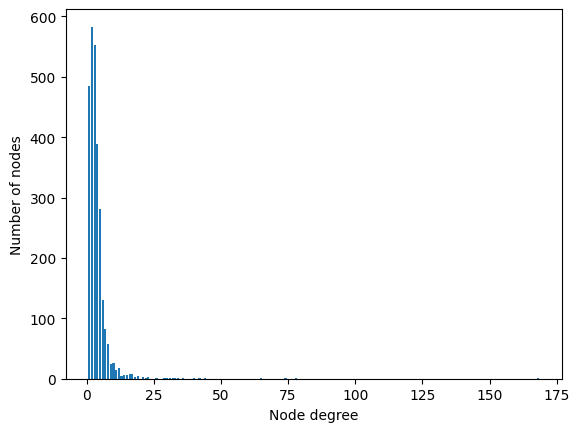

In [83]:
### Degree of nodes ###
degrees = degree(data.edge_index[0]).numpy()
numbers = Counter(degrees)
print(f'Degree of nodes: {numbers}')

### Plotting the degree distribution ###
fig, ax = plt.subplots()
ax.set_xlabel("Node degree")
ax.set_ylabel('Number of nodes')
plt.bar(numbers.keys(), numbers.values() )

In [84]:
def accuracy(y_pred, y_true):
    preds = y_pred.argmax(dim=1)
    correct = (preds == y_true).sum()
    return correct.float() / len(y_true)


In [96]:
### Defining the GCN model ###
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

        ### Initialise history for ploting ###
        self.train_losses = []
        self.val_losses = []
        self.val_accuracies = []

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

    ### training the model ###
    def fit(self, data, epochs):
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=0.01, weight_decay=5e-4)
        self.train()

        for epoch in range(epochs + 1):
            optimizer.zero_grad()
            out = self(data.x,data.edge_index)
            # Compute loss and backpropagate
            loss = criterion(out[data.train_mask], data.y[data.train_mask])
            loss.backward()
            optimizer.step()

            # Track losses and accuracy
            val_loss = criterion(out[data.val_mask], data.y[data.val_mask]).item()
            val_acc = accuracy(out[data.val_mask], data.y[data.val_mask]).item()

            self.train_losses.append(loss.item())
            self.val_losses.append(val_loss)
            self.val_accuracies.append(val_acc)

            if epoch % 20 == 0:
                print(f'Epoch {epoch:>3} | Train Loss: {loss.item():.3f}, Val Loss: {val_loss:.2f}, Val Acc: {val_acc*100:.2f}%')

    @torch.no_grad()
    def test(self, data):
        self.eval()
        out = self(data.x, data.edge_index)
        acc = accuracy(out[data.test_mask], data.y[data.test_mask])
        return acc.item()

    ### Plotting the training and validation loss ###
    def plot_loss(self):
        fig, ax = plt.subplots()
        ax.set_xlabel("Epoch")
        ax.set_ylabel('Loss')
        plt.plot(self.train_losses, label='Train Loss')
        plt.plot(self.val_losses, label='Validation Loss')
        plt.legend()
        plt.show()

    ### Plotting the accuracy ###
    def plot_accuracy(self):
        fig, ax = plt.subplots()
        ax.set_xlabel("Epoch")
        ax.set_ylabel('Accuracy')
        plt.plot(self.val_accuracies, label='Accuracy')
        plt.legend()
        plt.show()

In [97]:
### Let's instantiate and train the model ###
gcn = GCN(dataset.num_features, 16, dataset.num_classes)
print(gcn)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


In [87]:
gcn.fit(data, epochs=100)

Epoch   0 | Train Loss: 1.952, Val Loss: 1.95, Val Acc: 9.52%
Epoch  20 | Train Loss: 0.352, Val Loss: 0.43, Val Acc: 90.32%
Epoch  40 | Train Loss: 0.142, Val Loss: 0.33, Val Acc: 89.32%
Epoch  60 | Train Loss: 0.103, Val Loss: 0.34, Val Acc: 87.98%
Epoch  80 | Train Loss: 0.087, Val Loss: 0.35, Val Acc: 87.48%
Epoch 100 | Train Loss: 0.075, Val Loss: 0.36, Val Acc: 87.15%


In [88]:
acc = gcn.test(data)
print(f'GCN test accuracy: {acc*100:.2f}%')

GCN test accuracy: 85.15%


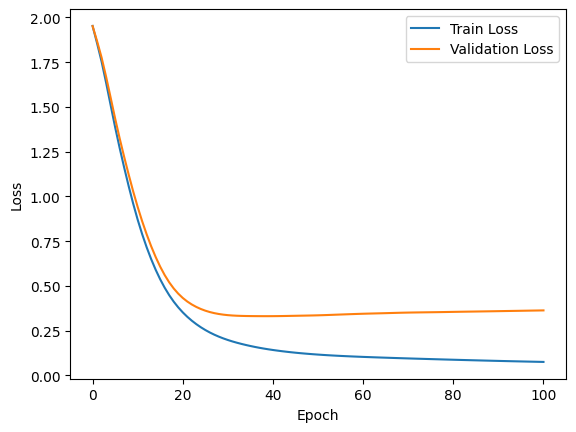

In [91]:
gcn.plot_loss()